# Imports

In [1]:
# Standard Library Imports
import sys
import os
import random
from pathlib import Path

# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

# Image Handling
from PIL import Image
import skimage
from skimage.io import imread, imsave

# Data Preparation and Splitting
from sklearn.model_selection import train_test_split

# Data Loading and Processing
from tqdm import tqdm
import tifffile as tiff
import rasterio

# Deep Learning Frameworks
import tensorflow as tf
import keras
import keras.layers

# Custom Module Imports
sys.path.insert(0, '../')
from src.utils import *
from src.config import *
from src.prepare_data import *

# Seed Setting
seed_value = 42

# Set the random seed for Python's built-in random module
random.seed(seed_value)

# Set the random seed for numpy
np.random.seed(seed_value)

# Set the random seed for TensorFlow
tf.random.set_seed(seed_value)


2023-08-31 14:34:48.866175: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 14:34:49.694459: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Setup

In [2]:
# Create the patches and divide them into train, validation and test sets
# prepare_biome8(patch_size=256, overlap=64, valid_test_size=0.2, test_size=0.5)

In [ ]:
# Chack the correct images size
get_biome8()[0].shape, get_biome8()[1].shape, get_biome8('valid')[0].shape, get_biome8('valid')[1].shape, get_biome8('test')[0].shape, get_biome8('test')[1].shape

In [ ]:
images, masks = get_biome8('test', only_rgb=True, full_image=True)

Loading data: 100%|██████████| 16/16 [00:34<00:00,  2.19s/it]


# Visualizations

The dataset is formed by 96 images of 8 different biomes. Each image is has a variable size and all the Landsat 8 bands are present. The images are in the GeoTIFF format and the labels are in the GeoJSON format.

In [ ]:
image_paths = sorted(list(biome_raw_dir.glob('**/*.TIF')))  # List of image file paths
mask_paths = sorted(list(biome_raw_dir.glob('**/*.img')))
# image_paths
# sorted(os.listdir(biome_raw_dir))
# LC80010112014080LGN00
# LC80010732013109LGN00
# /home/floddo/cloud_coverage_TOELT_SUPSI/Data/L8_Biome8/raw/Shrubland/BC/LC80010732013109LGN00

## Bands

We select an image from the shurbland biome and we plot it.

In [ ]:
# select a random image and load the RGB bands and the mask
ID = 'LC80010732013109LGN00'
B2 = tiff.imread(Path(biome_raw_dir, 'Shrubland/BC/', '{}/{}_B2.TIF'.format(ID, ID)))
B3 = tiff.imread(Path(biome_raw_dir, 'Shrubland/BC/', '{}/{}_B3.TIF'.format(ID, ID)))
B4 = tiff.imread(Path(biome_raw_dir, 'Shrubland/BC/', '{}/{}_B4.TIF'.format(ID, ID)))
B5 = tiff.imread(Path(biome_raw_dir, 'Shrubland/BC/', '{}/{}_B5.TIF'.format(ID, ID)))
im = np.dstack((B4, B3, B2))
im = np.clip(im/65536,0,1)

In [ ]:
# Flatten the array to a 1D array
flat_array = im.flatten()

# Calculate the statistical measures
min_value = np.min(flat_array)
max_value = np.max(flat_array)
mean_value = np.mean(flat_array)
median_value = np.median(flat_array)
std_deviation = np.std(flat_array)

# Print the statistical measures
print("Min value:", min_value)
print("Max value:", max_value)
print("Mean value:", mean_value)
print("Median value:", median_value)
print("Standard deviation:", std_deviation)

# Plot a histogram of the values
# plt.hist(flat_array, bins='auto')
# plt.title("Distribution of Image Values")
# plt.xlabel("Pixel Value")
# plt.ylabel("Frequency")
# plt.show()

Min value: 0.0
Max value: 0.9716949462890625
Mean value: 0.13706119929983282
Median value: 0.1505126953125
Standard deviation: 0.11720675148312731


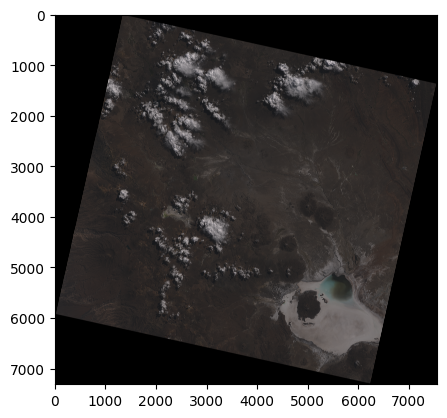

In [ ]:
# RGB image
plt.imshow(im)

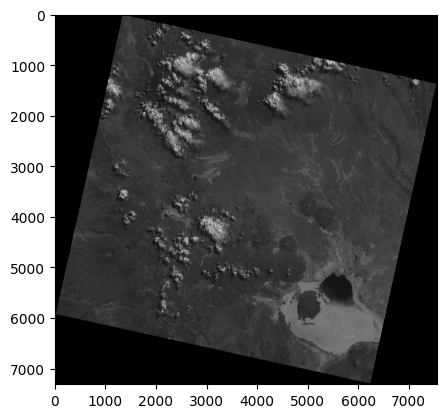

In [ ]:
# NIR image
plt.imshow(np.clip(B5/65536,0,1), cmap='gray')

## Mask

Image mask shape: (7311, 7561)
Image mask data type: uint8
Image mask unique values: {0, 64, 128, 192, 255}


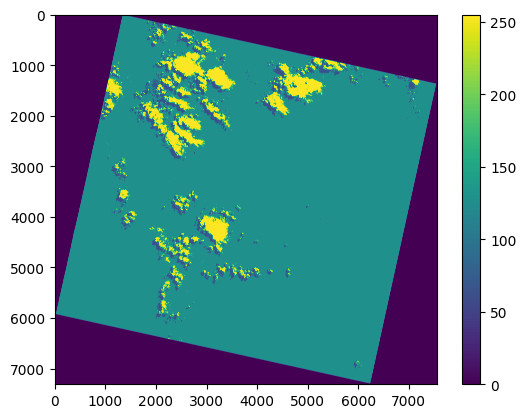

In [ ]:
# Specify the file path
file_path = Path(biome_raw_dir, 'Shrubland/BC/', "LC80010732013109LGN00/LC80010732013109LGN00_fixedmask.img")

# Open the image mask file
with rasterio.open(file_path) as dataset:
    # Access the image mask data
    image_mask = dataset.read(1)  # Assuming it is a single-band image, change the index if necessary

    # Perform operations on the image mask
    # For example, you can print some information about the image
    print("Image mask shape:", image_mask.shape)
    print("Image mask data type:", image_mask.dtype)
    print("Image mask unique values:", set(image_mask.flatten()))



# At this link we can find the meaning of the values in the mask: https://landsat.usgs.gov/landsat-8-cloud-cover-assessment-validation-data
# Value	   Interpretation
# 0	       Fill
# 64	   Cloud Shadow
# 128	   Clear
# 192	   Thin Cloud
# 255	   Cloud

# Plot the image mask
plt.imshow(image_mask)
plt.colorbar()


## Side by side

In [ ]:
# Plot 5 random images
np.random.seed(seed_value)
idxs = np.random.randint(len(images), size=5)

ims = images[idxs]
ms = masks[idxs]

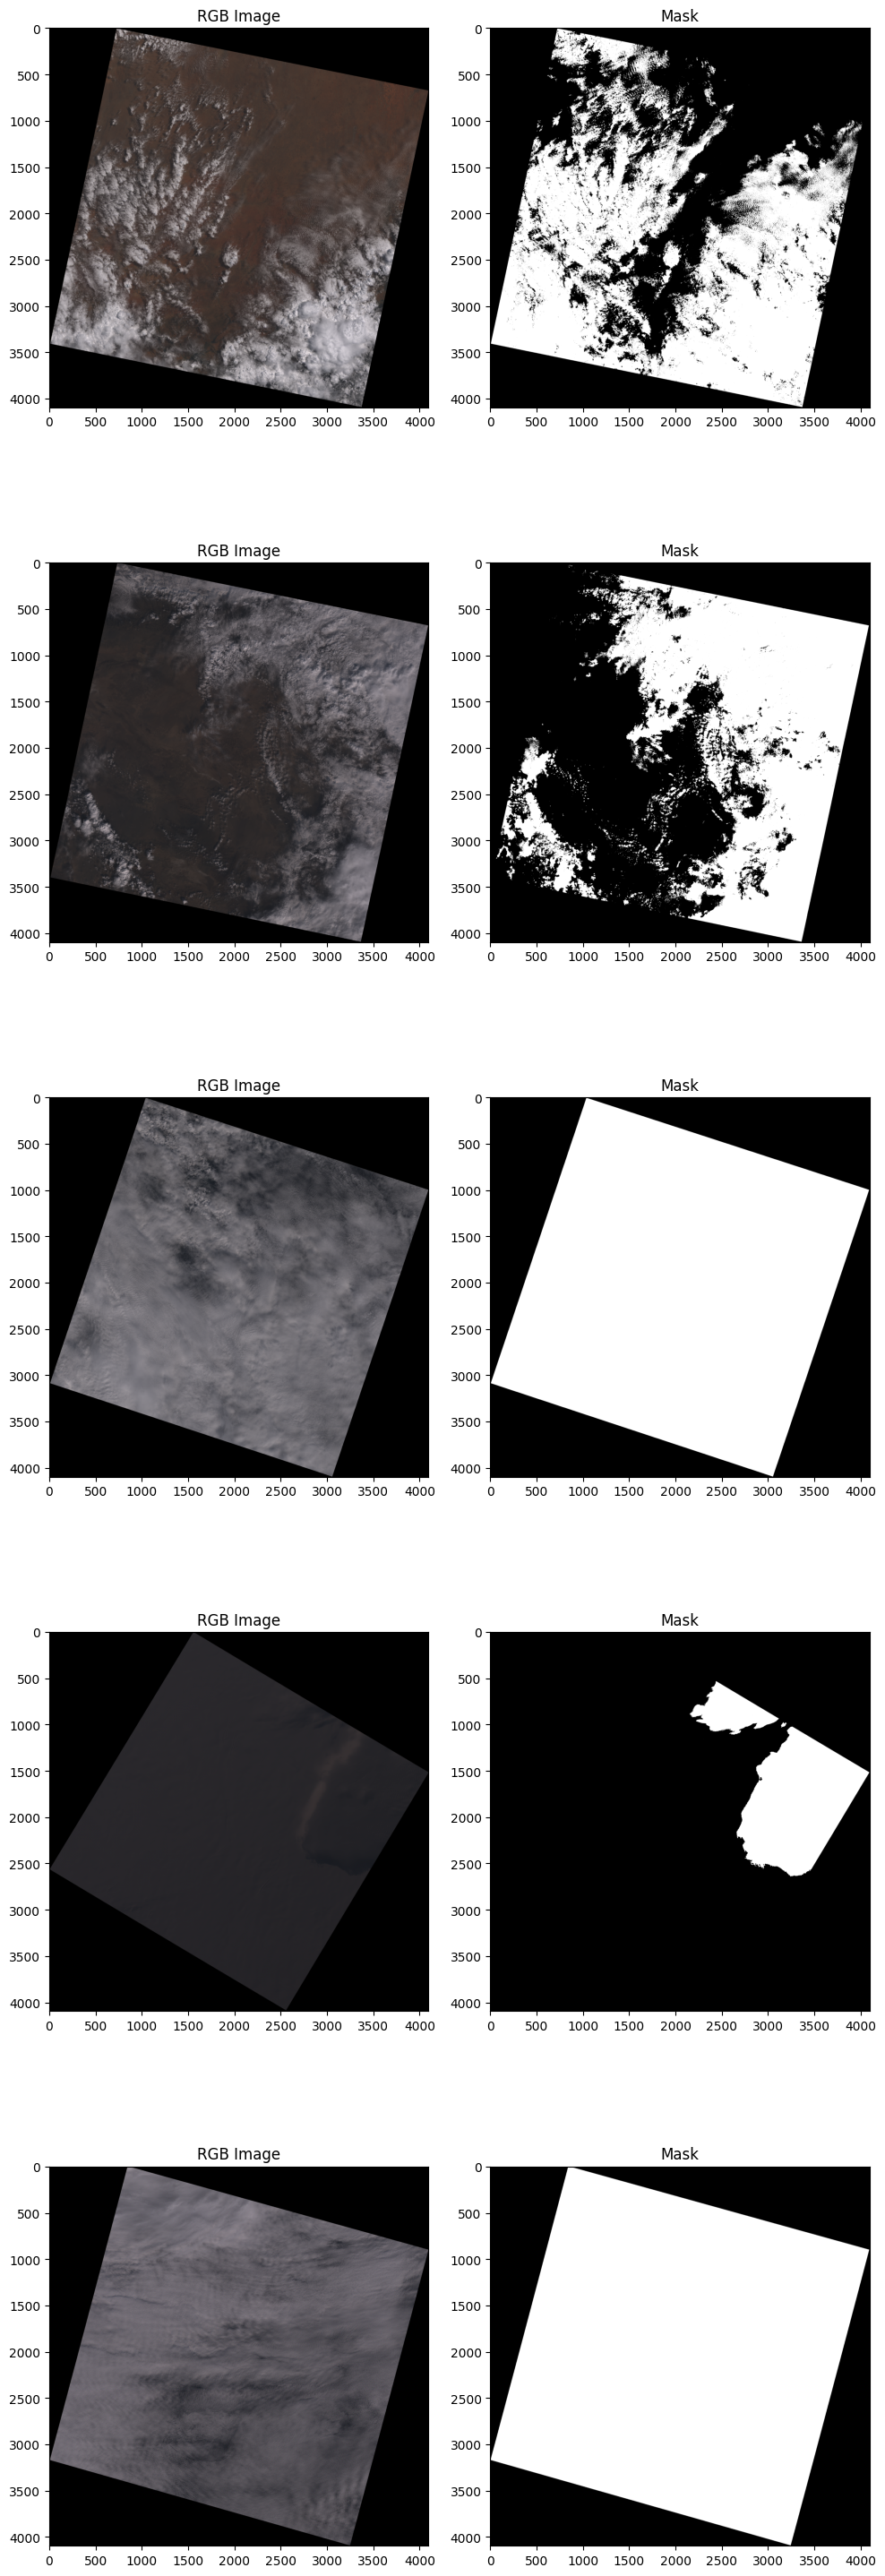

In [ ]:
fig, ax = plt.subplots(len(idxs), 2, figsize=(10, 30))

for i in range(len(idxs)):
    ax[i, 0].imshow(ims[i])
    ax[i, 0].set_title('RGB Image')
    ax[i, 1].imshow(ms[i] == 1 , cmap='gray')
    ax[i, 1].set_title('Mask')

# Adjust the spacing between subplots
plt.tight_layout()

# # Display the figure
plt.show()

# Distribution

In [ ]:
folders = sorted(os.listdir(biome_raw_dir))


biome_pixels_per_class = np.zeros((96, 5))  # 96 products with 5 classes
biome_band_mean_per_product = np.zeros((96, 10))  # 96 products with 10 bands (discard band 8)
biome_band_std_per_product = np.zeros((96, 10))  # 96 products with 10 bands
biome_band_max_per_product = np.zeros((96, 10))  # 96 products with 10 bands
# Have at least one pixel for each class to avoid issues with the colors in the figure
biome_classes = np.zeros((5))
biome_classes[0] = 0
biome_classes[1] = 64
biome_classes[2] = 128
biome_classes[3] = 192
biome_classes[4] = 255

i = 0

for folder in folders:
    products = sorted(os.listdir(biome_raw_dir / folder / "BC"))
    print('Processing products with ' + folder + ' background')
    for product in products:
        raw_path = biome_raw_dir / folder / "BC" / product
        mask = read_and_close(raw_path /  (product + "_fixedmask.img"))
        
        for j, c in enumerate(biome_classes):
            biome_pixels_per_class[i, j] = np.count_nonzero(mask == c)        
        
        for j in range(1, 12):
            img_band = tiff.imread(raw_path / (product + "_B" + str(j) + ".TIF"))
            img_band = img_band[img_band != 0]  # Discard fill pixels
            biome_band_mean_per_product[i, j-2] = np.mean(img_band)
            biome_band_std_per_product[i, j-2] = np.std(img_band)  
            biome_band_max_per_product[i, j-2] = np.percentile(img_band, 0.98)  # Discard uppermost 2 percent to ignore outliers
            
        i += 1

Processing products with Barren background
Processing products with Forest background
Processing products with GrassCrops background
Processing products with Shrubland background
Processing products with SnowIce background
Processing products with Urban background
Processing products with Water background
Processing products with Wetlands background


Mean values
Band 1       1.906206
Band 2       1.814004
Band 3       1.854572
Band 4       2.127634
Band 5       1.379618
Band 6       1.193472
Band 7       1.825382
Band 9       0.630895
Band 10    272.951184
Band 11    270.469265
dtype: float64
Std values
Band 1       0.486637
Band 2       0.483401
Band 3       0.519451
Band 4       0.530060
Band 5       0.363760
Band 6       0.294779
Band 7       0.497593
Band 9       0.103860
Band 10    193.592683
Band 11    184.647540
dtype: float64
Max values
Band 1       3.971200
Band 2       3.752500
Band 3       3.824500
Band 4       4.058400
Band 5       1.494900
Band 6       1.387300
Band 7       3.781900
Band 9       0.788800
Band 10    314.251075
Band 11    317.154555
dtype: float64


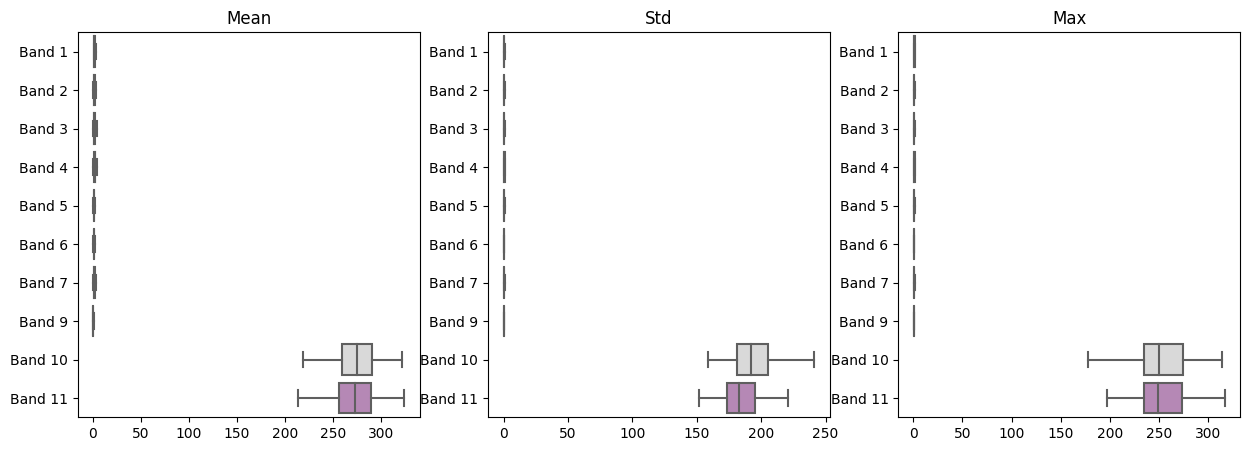

In [ ]:
oli_scaling = 10000  # This number comes from the scaling factor in the TOA algorithm in the Python Fmask package

# Scaling for TIRS instrument (band 10 and 11) is from https://landsat.usgs.gov/using-usgs-landsat-8-product
RADIANCE_MULT_BAND_10 = 3.3420E-04  # Parameters from any of the Landsat 8 mtl files
RADIANCE_MULT_BAND_11 = 3.3420E-04
RADIANCE_ADD_BAND_10 = 0.10000
RADIANCE_ADD_BAND_11 = 0.10000
K1_CONSTANT_BAND_10 = 774.89  
K1_CONSTANT_BAND_11 = 480.89
K2_CONSTANT_BAND_10 = 1321.08
K2_CONSTANT_BAND_11 = 1201.14

df_biome_mean = pd.DataFrame({'Band 1':biome_band_mean_per_product[:,0]/oli_scaling,
                              'Band 2':biome_band_mean_per_product[:,1]/oli_scaling,
                              'Band 3':biome_band_mean_per_product[:,2]/oli_scaling,
                              'Band 4':biome_band_mean_per_product[:,3]/oli_scaling,
                              'Band 5':biome_band_mean_per_product[:,4]/oli_scaling,
                              'Band 6':biome_band_mean_per_product[:,5]/oli_scaling,
                              'Band 7':biome_band_mean_per_product[:,6]/oli_scaling,                              
                              'Band 9':biome_band_mean_per_product[:,7]/oli_scaling,
                              'Band 10':K2_CONSTANT_BAND_10/(np.log(K1_CONSTANT_BAND_10/(RADIANCE_MULT_BAND_10*biome_band_mean_per_product[:,8] + RADIANCE_ADD_BAND_10) + 1)),
                              'Band 11':K2_CONSTANT_BAND_11/(np.log(K1_CONSTANT_BAND_11/(RADIANCE_MULT_BAND_11*biome_band_mean_per_product[:,9] + RADIANCE_ADD_BAND_11) + 1))})

df_biome_std = pd.DataFrame({'Band 1':biome_band_std_per_product[:,0]/oli_scaling,
                             'Band 2':biome_band_std_per_product[:,1]/oli_scaling,
                             'Band 3':biome_band_std_per_product[:,2]/oli_scaling,
                             'Band 4':biome_band_std_per_product[:,3]/oli_scaling,
                             'Band 5':biome_band_std_per_product[:,4]/oli_scaling,
                             'Band 6':biome_band_std_per_product[:,5]/oli_scaling,
                             'Band 7':biome_band_std_per_product[:,6]/oli_scaling,
                             'Band 9':biome_band_std_per_product[:,7]/oli_scaling,
                             'Band 10':K2_CONSTANT_BAND_10/(np.log(K1_CONSTANT_BAND_10/(RADIANCE_MULT_BAND_10*biome_band_std_per_product[:,8] + RADIANCE_ADD_BAND_10) + 1)),
                             'Band 11':K2_CONSTANT_BAND_11/(np.log(K1_CONSTANT_BAND_11/(RADIANCE_MULT_BAND_11*biome_band_std_per_product[:,9] + RADIANCE_ADD_BAND_11) + 1))})

df_biome_max = pd.DataFrame({'Band 1':biome_band_max_per_product[:,0]/oli_scaling,
                             'Band 2':biome_band_max_per_product[:,1]/oli_scaling,
                             'Band 3':biome_band_max_per_product[:,2]/oli_scaling,
                             'Band 4':biome_band_max_per_product[:,3]/oli_scaling,
                             'Band 5':biome_band_max_per_product[:,4]/oli_scaling,
                             'Band 6':biome_band_max_per_product[:,5]/oli_scaling,
                             'Band 7':biome_band_max_per_product[:,6]/oli_scaling,
                             'Band 9':biome_band_max_per_product[:,7]/oli_scaling,
                             'Band 10':K2_CONSTANT_BAND_10/(np.log(K1_CONSTANT_BAND_10/(RADIANCE_MULT_BAND_10*biome_band_max_per_product[:,8] + RADIANCE_ADD_BAND_10) + 1)),
                             'Band 11':K2_CONSTANT_BAND_11/(np.log(K1_CONSTANT_BAND_11/(RADIANCE_MULT_BAND_11*biome_band_max_per_product[:,9] + RADIANCE_ADD_BAND_11) + 1))})

print('Mean values')
print(df_biome_mean.mean())

print('Std values')
print(df_biome_std.mean())

print('Max values')
print(df_biome_max.max())

# Plot 
plt.figure(figsize=(15, 5))
order = ["Band 1", "Band 2", "Band 3", "Band 4", "Band 5", "Band 6", "Band 7", 
         "Band 9", "Band 10", "Band 11"]

plt.subplot(1, 3, 1)
plt.title('Mean')
sns.boxplot(data=df_biome_mean, order=order, palette="Set3",  orient="h", showfliers=False)

plt.subplot(1, 3, 2)
plt.title('Std')
sns.boxplot(data=df_biome_std, order=order, palette="Set3",  orient="h", showfliers=False)

plt.subplot(1, 3, 3)
plt.title('Max')
sns.boxplot(data=df_biome_max, order=order, palette="Set3",  orient="h", showfliers=False)

plt.show()

In [ ]:
df_biome_mask = pd.DataFrame({'Fill':biome_pixels_per_class[:,0],
                              'Cloud Shadow':biome_pixels_per_class[:,1],
                              'Clear':biome_pixels_per_class[:,2],
                              'Thin Cloud':biome_pixels_per_class[:,3],
                              'Cloud':biome_pixels_per_class[:,4]})

df_biome_mask.head(5)

,Fill,Cloud Shadow,Clear,Thin Cloud,Cloud
0,37808321.0,0.0,41864930.0,0.0,0.0
1,33742419.0,0.0,782290.0,5939148.0,35155934.0
2,40678660.0,0.0,41876511.0,0.0,0.0
3,17375002.0,0.0,32038717.0,4835216.0,4743926.0
4,21311253.0,0.0,9593588.0,11559058.0,20433262.0


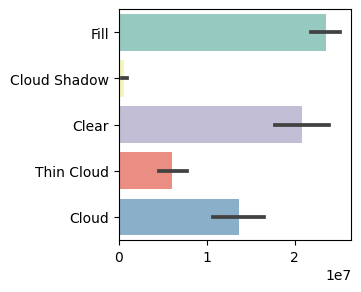

In [ ]:
# Draw a count plot
plt.figure(figsize=(3, 3))
sns.barplot(data=df_biome_mask, palette="Set3",  orient="h")
plt.show()

# Sources:

Data distribution: https://github.com/JacobJeppesen/RS-Net/blob/master/notebooks/jhj_ArticleFigures_DatasetDistributions.ipynb